In [1]:
# Importing the required packages
import calliope
import pandas as pd
from spores_algorithm import run_spores
from plotting_utilities import plot_dispatch, plot_capacity, plot_network
import matplotlib.pyplot as plt

import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import matplotlib.dates as mdates
import numpy as np
import xarray as xr

# Setting the verbosity level for Calliope
calliope.set_log_verbosity('INFO', include_solver_output=False) # Defines how much information you get 
                                                               #from the machine as the model gets built and run

Loads all SPORE NetCDF result files, extracts and aggregates the variable `cost_operation_variable` by timestep for each SPORE, and constructs a matrix where each row is a SPORE and each column is a timestep.

In [2]:
# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')  # Adjust this if needed

# Initialize an empty list to hold the aggregated data for each SPORE
aggregated_data_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Convert source capacities to DataFrame
    data_df = data['cost_operation_variable'].to_dataframe().reset_index()
    data_df = data_df[~data_df['techs'].str.contains(r'_to_', regex=True)]
    data_df = data_df.dropna(subset=['cost_operation_variable'])
    
    # Aggregate the source capacities by tech
    aggregated_source_cap = data_df.groupby('timesteps')['cost_operation_variable'].sum().reset_index()
    
    # Convert the aggregated source capacities into a series with tech as the index
    aggregated_series = aggregated_source_cap.set_index('timesteps')['cost_operation_variable']
    
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    aggregated_series.name = spore_name  # Name the row by the SPORE name

    # Append the aggregated data (this will form the rows in the final matrix)
    aggregated_data_list.append(aggregated_series)

# Combine all SPORE aggregated data into a single DataFrame (with each SPORE as a row)
aggregated_matrix = pd.concat(aggregated_data_list, axis=1).T

# Set the column names to be the techs
aggregated_matrix.columns = aggregated_source_cap['timesteps']

# Show the resulting matrix
aggregated_matrix


timesteps,2019-01-01 00:00:00,2019-01-01 03:00:00,2019-01-01 06:00:00,2019-01-01 09:00:00,2019-01-01 12:00:00,2019-01-01 15:00:00,2019-01-01 18:00:00,2019-01-01 21:00:00,2019-01-02 00:00:00,2019-01-02 03:00:00,...,2019-01-06 18:00:00,2019-01-06 21:00:00,2019-01-07 00:00:00,2019-01-07 03:00:00,2019-01-07 06:00:00,2019-01-07 09:00:00,2019-01-07 12:00:00,2019-01-07 15:00:00,2019-01-07 18:00:00,2019-01-07 21:00:00
spores\maxbat_spore_1,-1944.813904,-2370.842326,-2142.111994,-2537.943889,-2849.434121,-1979.799681,-2305.591358,-2721.467272,-2950.215868,-2530.100931,...,2949.557898,2447.586679,882.669416,2043.620617,2641.852765,2066.769016,-139.833418,-563.694848,-1700.703936,-2752.079188
spores\maxbat_spore_2,-1943.685133,-2369.407859,-2140.350305,-2536.040309,-2846.913978,-1979.102082,-2304.459718,-2719.699707,-2947.320731,-2528.608438,...,2933.692105,2432.079792,880.790897,2000.107683,2625.757702,2054.533720,-141.489009,-564.928170,-1700.360199,-2750.043862
spores\maxbat_spore_3,-1943.470205,-2369.449700,-2146.708844,-2536.808323,-2848.456946,-1978.810759,-2304.385264,-2720.056592,-2948.779756,-2528.739021,...,2939.028383,2436.081725,880.768445,2012.975443,2629.089364,2057.165324,-141.428132,-564.837386,-1700.204766,-2742.854567
spores\maxbat_spore_4,-1929.021314,-2366.278242,-2125.876281,-2537.090610,-2859.807828,-1993.049093,-2318.138877,-2731.773412,-2956.888818,-2542.158589,...,2882.657422,2384.229193,878.859491,1910.167868,2580.213550,2019.636467,-140.404878,-562.858987,-1712.113033,-2761.653775
spores\maxbat_spore_5,-1873.384342,-2346.702630,-2111.576093,-2527.660868,-2881.598109,-2015.536653,-2340.258093,-2753.809732,-2980.731063,-2550.961886,...,2825.521519,2328.713557,867.189341,1901.254030,2533.861911,1976.610969,-127.597764,-544.846819,-1689.133799,-2784.222652
spores\maxbio_spore_1,-77.271261,-378.099260,-287.602455,-542.802967,-705.340147,-61.875942,-286.866909,-568.236545,-693.857395,-458.379297,...,3442.363831,2393.938607,1780.230502,2072.905431,3633.293643,2857.042073,1601.615898,1149.958959,227.661831,-527.698386
spores\maxbio_spore_2,-145.182488,-338.198264,-277.826429,-414.039302,-546.164089,-103.246975,-238.726571,-424.764494,-525.311517,-367.088839,...,3273.783315,2582.584779,2017.921937,2160.268279,3339.024190,2757.400595,1505.066993,873.809207,83.589319,-387.198284
spores\maxbio_spore_3,4742.854163,4061.166033,4073.638108,3561.316647,3313.388399,4268.709434,3817.787327,3333.303806,3015.238534,3658.690196,...,7586.976155,7083.702744,6736.521387,6832.694938,7755.992033,7418.369040,6287.326047,5553.501734,4280.659140,2925.979770
spores\maxbio_spore_4,-135.019248,-474.833504,-341.023730,-888.576563,-959.926450,80.710690,-223.745527,-655.286036,-905.529702,-544.978777,...,1978.522180,1457.717114,1101.533690,1268.247714,2261.547331,1964.066692,1416.838992,1227.333902,348.664791,-651.223446
spores\maxbio_spore_5,-528.252075,-747.938469,-658.001156,-853.133880,-982.635158,-298.881594,-506.771179,-800.263733,-953.849833,-757.688765,...,1192.330825,761.399801,460.275919,602.347964,1436.740053,1141.985482,703.990480,557.828903,-99.602102,-741.628243


Standardizes the aggregated matrix data using `StandardScaler` to prepare for clustering.

In [3]:
# Standardize the data
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(aggregated_matrix)  # Normalize across all technologies

Uses the Elbow Method to determine the optimal number of clusters (K) for KMeans by plotting inertia.

[2025-05-28 10:18:42] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(

[2025-05-28 10:18:42] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(

[2025-05-28 10:18:42] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment varia

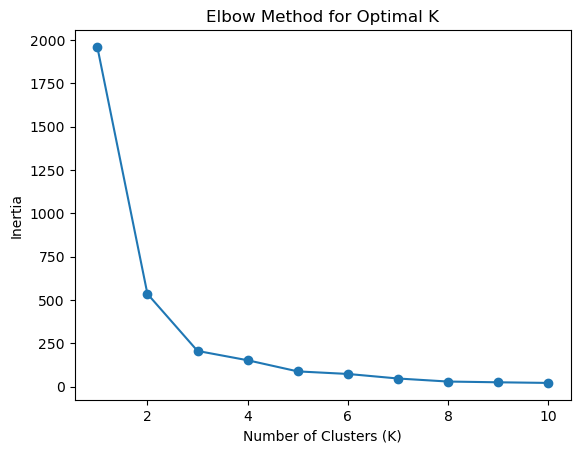

In [4]:
# Try different values of K and calculate the inertia (sum of squared distances)
inertia = []
k_range = range(1, 11)  # Test for K = 1 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(matrix_scaled)
    inertia.append(kmeans.inertia_)

# Plot inertia to find the "elbow" point
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()


Applies DBSCAN clustering to the standardized data and prints the number of clusters found.

In [5]:
# Apply DBSCAN with eps=0.5 and min_samples=5
db = DBSCAN(eps=0.5, min_samples=5)
db_labels = db.fit_predict(matrix_scaled)

# Check the number of distinct clusters
print(f"Number of clusters found by DBSCAN: {len(set(db_labels)) - (1 if -1 in db_labels else 0)}")

Number of clusters found by DBSCAN: 2


Finds the best number of clusters (K) for KMeans using the silhouette score.

In [6]:
# Set the initial best score and best K
best_score = -1
best_k = 2  # Start with 2 clusters

# Try different values of K and calculate the silhouette score
k_values = range(2, 6)  # Try smaller values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(matrix_scaled)
    
    # Check if there are more than 1 unique labels
    if len(set(kmeans.labels_)) > 1:
        score = silhouette_score(matrix_scaled, kmeans.labels_)
        if score > best_score:
            best_score = score
            best_k = k

print(f"Best number of clusters (K) by silhouette score: {best_k}")

[2025-05-28 10:18:43] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(

[2025-05-28 10:18:43] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(

[2025-05-28 10:18:43] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment varia

Performs PCA to reduce the data to 2 dimensions and plots the SPOREs in the PCA space.

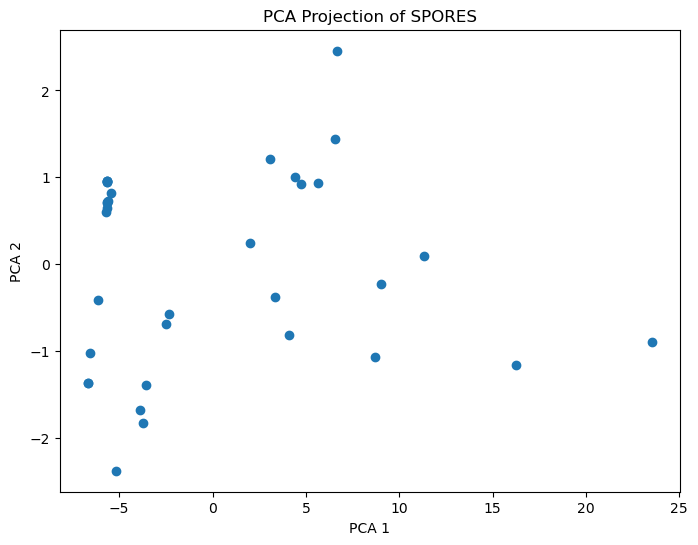

In [7]:
# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(matrix_scaled)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA Projection of SPORES')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

Applies KMeans clustering to the standardized data, assigns cluster labels, and adds them to the aggregated matrix.

In [8]:
# Apply K-means with the chosen number of clusters (e.g., best_k)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(matrix_scaled)

# Add the cluster labels to the DataFrame
aggregated_matrix['Cluster'] = kmeans_labels

# Show the results
aggregated_matrix


[2025-05-28 10:18:43] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



timesteps,2019-01-01 00:00:00,2019-01-01 03:00:00,2019-01-01 06:00:00,2019-01-01 09:00:00,2019-01-01 12:00:00,2019-01-01 15:00:00,2019-01-01 18:00:00,2019-01-01 21:00:00,2019-01-02 00:00:00,2019-01-02 03:00:00,...,2019-01-06 21:00:00,2019-01-07 00:00:00,2019-01-07 03:00:00,2019-01-07 06:00:00,2019-01-07 09:00:00,2019-01-07 12:00:00,2019-01-07 15:00:00,2019-01-07 18:00:00,2019-01-07 21:00:00,Cluster
spores\maxbat_spore_1,-1944.813904,-2370.842326,-2142.111994,-2537.943889,-2849.434121,-1979.799681,-2305.591358,-2721.467272,-2950.215868,-2530.100931,...,2447.586679,882.669416,2043.620617,2641.852765,2066.769016,-139.833418,-563.694848,-1700.703936,-2752.079188,0
spores\maxbat_spore_2,-1943.685133,-2369.407859,-2140.350305,-2536.040309,-2846.913978,-1979.102082,-2304.459718,-2719.699707,-2947.320731,-2528.608438,...,2432.079792,880.790897,2000.107683,2625.757702,2054.533720,-141.489009,-564.928170,-1700.360199,-2750.043862,0
spores\maxbat_spore_3,-1943.470205,-2369.449700,-2146.708844,-2536.808323,-2848.456946,-1978.810759,-2304.385264,-2720.056592,-2948.779756,-2528.739021,...,2436.081725,880.768445,2012.975443,2629.089364,2057.165324,-141.428132,-564.837386,-1700.204766,-2742.854567,0
spores\maxbat_spore_4,-1929.021314,-2366.278242,-2125.876281,-2537.090610,-2859.807828,-1993.049093,-2318.138877,-2731.773412,-2956.888818,-2542.158589,...,2384.229193,878.859491,1910.167868,2580.213550,2019.636467,-140.404878,-562.858987,-1712.113033,-2761.653775,0
spores\maxbat_spore_5,-1873.384342,-2346.702630,-2111.576093,-2527.660868,-2881.598109,-2015.536653,-2340.258093,-2753.809732,-2980.731063,-2550.961886,...,2328.713557,867.189341,1901.254030,2533.861911,1976.610969,-127.597764,-544.846819,-1689.133799,-2784.222652,0
spores\maxbio_spore_1,-77.271261,-378.099260,-287.602455,-542.802967,-705.340147,-61.875942,-286.866909,-568.236545,-693.857395,-458.379297,...,2393.938607,1780.230502,2072.905431,3633.293643,2857.042073,1601.615898,1149.958959,227.661831,-527.698386,0
spores\maxbio_spore_2,-145.182488,-338.198264,-277.826429,-414.039302,-546.164089,-103.246975,-238.726571,-424.764494,-525.311517,-367.088839,...,2582.584779,2017.921937,2160.268279,3339.024190,2757.400595,1505.066993,873.809207,83.589319,-387.198284,0
spores\maxbio_spore_3,4742.854163,4061.166033,4073.638108,3561.316647,3313.388399,4268.709434,3817.787327,3333.303806,3015.238534,3658.690196,...,7083.702744,6736.521387,6832.694938,7755.992033,7418.369040,6287.326047,5553.501734,4280.659140,2925.979770,2
spores\maxbio_spore_4,-135.019248,-474.833504,-341.023730,-888.576563,-959.926450,80.710690,-223.745527,-655.286036,-905.529702,-544.978777,...,1457.717114,1101.533690,1268.247714,2261.547331,1964.066692,1416.838992,1227.333902,348.664791,-651.223446,0
spores\maxbio_spore_5,-528.252075,-747.938469,-658.001156,-853.133880,-982.635158,-298.881594,-506.771179,-800.263733,-953.849833,-757.688765,...,761.399801,460.275919,602.347964,1436.740053,1141.985482,703.990480,557.828903,-99.602102,-741.628243,0


Extracts a general SPORE category from each configuration, groups by cluster and category, and counts the occurrences in a summary table.

In [9]:
# Dynamically extract the general SPORE category from the 'techs' index by splitting the names
aggregated_matrix_count = aggregated_matrix.copy()

aggregated_matrix_count['spore_category_general'] = aggregated_matrix_count.index.to_series().apply(lambda x: x.split('_spore')[0])

# Now, group by 'Cluster' and 'spore_category_general' and count the occurrences
cluster_spore_count = aggregated_matrix_count.groupby(['Cluster', 'spore_category_general']).size().unstack(fill_value=0)

# Show the resulting table
cluster_spore_count

spore_category_general,spores\maxbat,spores\maxbio,spores\maxhyd,spores\maxnuc,spores\minbat,spores\minhyd,spores\minnuc
Cluster,,,,,,,
0,5,4,5,5,0,0,2
1,0,0,0,0,2,1,0
2,0,1,0,0,3,4,3


Calculates and displays the mean value for each technology in each cluster.

In [10]:
# Group by 'Cluster' and calculate the mean for each technology
cluster_summary = aggregated_matrix.groupby('Cluster').mean()

# Show the resulting cluster summary
cluster_summary


timesteps,2019-01-01 00:00:00,2019-01-01 03:00:00,2019-01-01 06:00:00,2019-01-01 09:00:00,2019-01-01 12:00:00,2019-01-01 15:00:00,2019-01-01 18:00:00,2019-01-01 21:00:00,2019-01-02 00:00:00,2019-01-02 03:00:00,...,2019-01-06 18:00:00,2019-01-06 21:00:00,2019-01-07 00:00:00,2019-01-07 03:00:00,2019-01-07 06:00:00,2019-01-07 09:00:00,2019-01-07 12:00:00,2019-01-07 15:00:00,2019-01-07 18:00:00,2019-01-07 21:00:00
Cluster,,,,,,,,,,,,,,,,,,,,,
0,-1350.676980,-1774.296171,-1592.987479,-1990.992353,-2232.369692,-1377.101416,-1684.937699,-2069.864042,-2274.224293,-1910.747924,...,2504.143129,1935.520597,823.915452,1214.476118,2510.224729,1955.732756,348.765940,-79.979448,-1104.962950,-2066.964515
1,7840.211299,7394.743868,7470.769155,6901.944902,6819.058312,7925.679135,7520.622058,6993.533196,6553.524890,7165.884410,...,10415.592703,9878.272698,9516.733066,9685.434443,10641.114552,10281.102588,9669.538185,9345.200948,8149.102393,7046.172002
2,2464.430513,1898.181824,2030.596468,1554.740841,1350.218155,2610.883835,2160.430388,1534.399833,1203.288068,1761.368177,...,6663.994005,5811.751243,5156.642333,5441.563130,6915.951757,6342.732647,5155.378130,4522.790710,3028.591773,1577.698551


Plots the centroid values (mean per cluster) over time for each cluster.

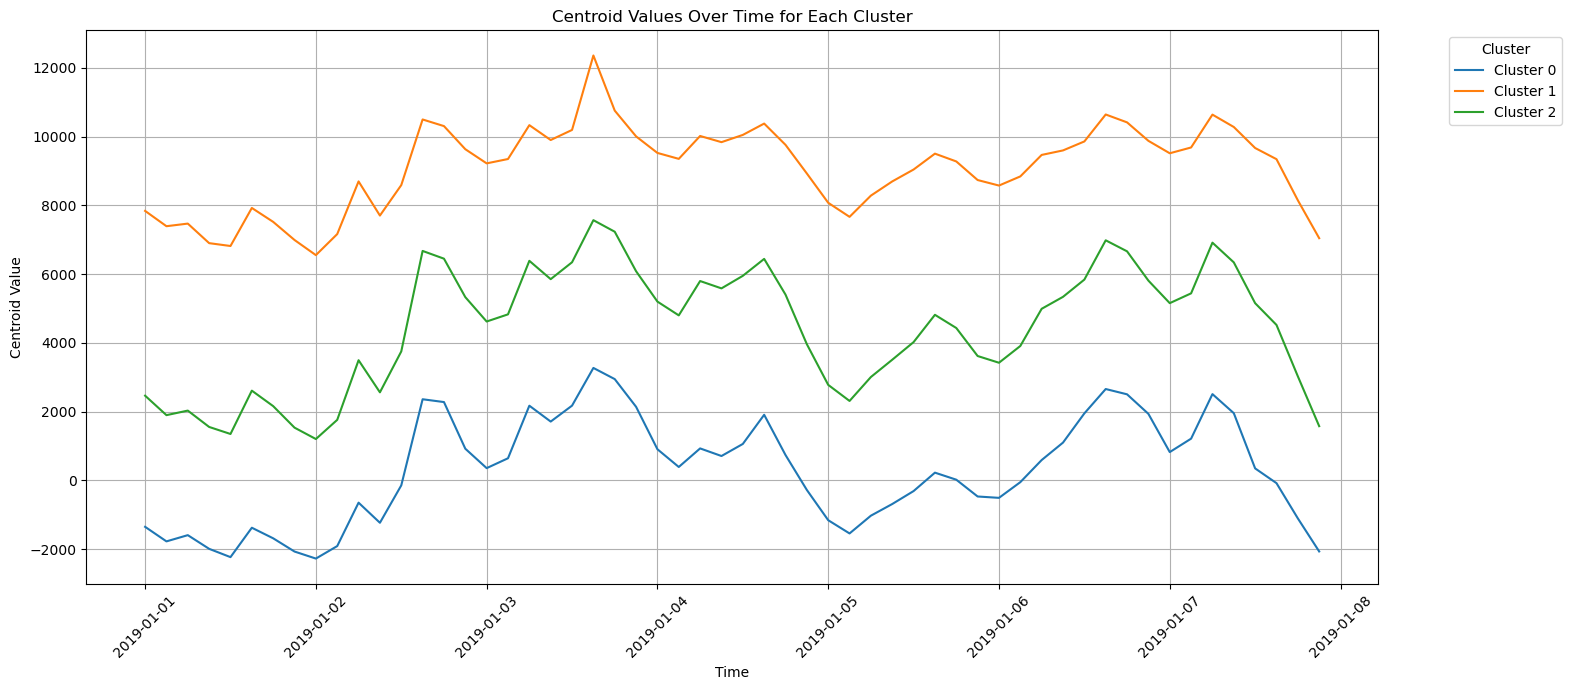

In [11]:
# Let's plot the data (one line for each cluster)
plt.figure(figsize=(14, 7))

# Loop through each cluster (row) and plot its centroid values over time (columns)
for cluster in cluster_summary.index:
    plt.plot(cluster_summary.columns, cluster_summary.loc[cluster], label=f'Cluster {cluster}')

# Add titles and labels
plt.title('Centroid Values Over Time for Each Cluster')
plt.xlabel('Time')
plt.ylabel('Centroid Value')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Finds the configuration closest to the centroid for each cluster (representative configuration) and plots their time series.

Cluster 0 - Shape of cluster_configs: (21, 56)
Cluster 2 - Shape of cluster_configs: (11, 56)
Cluster 1 - Shape of cluster_configs: (3, 56)
Representative configurations: ['spores\\maxhyd_spore_2', 'spores\\minnuc_spore_3', 'spores\\minbat_spore_5']


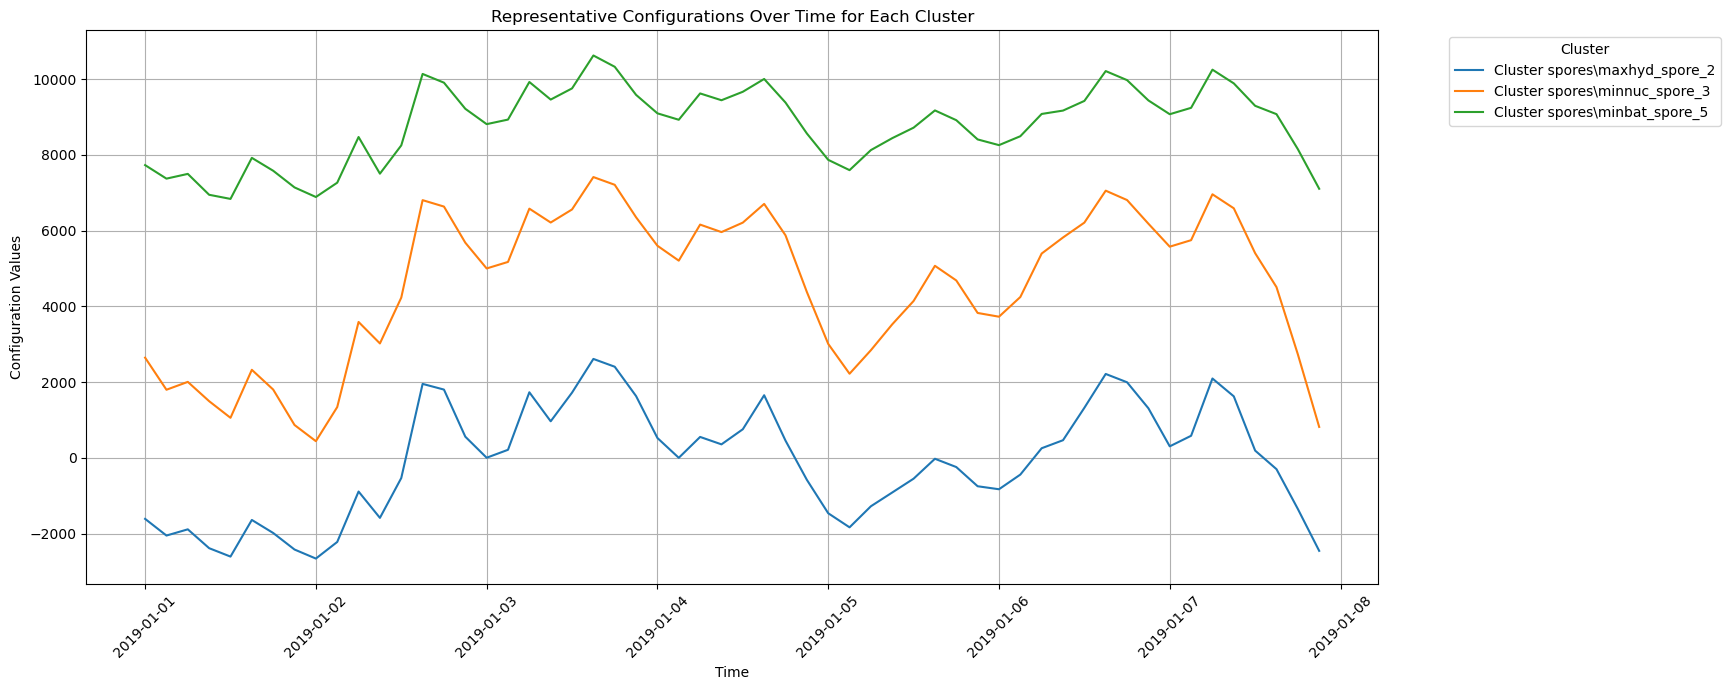

In [12]:
# 1. Compute the centroids of each cluster (mean of each technology in each cluster)
cluster_centroids = aggregated_matrix.groupby('Cluster').mean()

# 2. Find the configuration closest to the centroid for each cluster
representative_configs = []

for cluster in aggregated_matrix['Cluster'].unique():
    # Get the configurations in the current cluster
    cluster_configs = aggregated_matrix[aggregated_matrix['Cluster'] == cluster].drop(columns=['Cluster'])

    # Print the shape of the data to verify it's correct
    print(f"Cluster {cluster} - Shape of cluster_configs: {cluster_configs.shape}")

    # Calculate the centroid for the current cluster
    centroid = cluster_centroids.loc[cluster]

    # Compute the Euclidean distances between each configuration and the centroid
    distances = cdist(cluster_configs, centroid.values.reshape(1, -1), metric='euclidean')

    # Get the index of the closest configuration (minimum distance)
    closest_index = np.argmin(distances)
    representative_config = cluster_configs.iloc[closest_index].name

    # Append the representative configuration's index
    representative_configs.append(representative_config)

# Print the representative configurations' indices
print(f"Representative configurations: {representative_configs}")

# 3. Retrieve the representative configurations from the 'aggregated_matrix'
df_representative_configs = aggregated_matrix.loc[representative_configs].drop(columns=['Cluster'])

plt.figure(figsize=(14, 7))

# Loop through each configuration in 'df_representative_configs' and plot the time series for each cluster
for config in df_representative_configs.index:
    # Extract the time series for the current configuration
    config_data = df_representative_configs.loc[config]
    
    # Plot the configuration over time
    plt.plot(df_representative_configs.columns, config_data, label=f'Cluster {config}')

# Customize the plot
plt.title('Representative Configurations Over Time for Each Cluster')
plt.xlabel('Time')
plt.ylabel('Configuration Values')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Computes various statistical metrics (max, min, mean, variance, percentiles, etc.) for each representative configuration and displays them in a table.

In [13]:
# 1. Compute the metrics for each configuration
metrics = {
    'max_value': df_representative_configs.max(axis=1),
    'min_value': df_representative_configs.min(axis=1),
    'mean_value': df_representative_configs.mean(axis=1),
    'variance_value': df_representative_configs.var(axis=1),
    'std_dev_value': df_representative_configs.std(axis=1),
    'range_value': df_representative_configs.max(axis=1) - df_representative_configs.min(axis=1),
    'percentile_25': df_representative_configs.quantile(0.25, axis=1),
    'percentile_50': df_representative_configs.quantile(0.5, axis=1),
    'percentile_75': df_representative_configs.quantile(0.75, axis=1),
}

# Convert the metrics to a DataFrame for easy visualization
metrics_df = pd.DataFrame(metrics)

metrics_df

,max_value,min_value,mean_value,variance_value,std_dev_value,range_value,percentile_25,percentile_50,percentile_75
spores\maxhyd_spore_2,2614.328635,-2654.979384,-89.922373,2.224294e+06,1491.406625,5269.308019,-1373.246385,5.388997,1054.221835
spores\minnuc_spore_3,7414.624860,443.379883,4563.226146,3.904203e+06,1975.905735,6971.244978,2970.458247,5123.501032,6212.297094
spores\minbat_spore_5,10623.697876,6838.076363,8788.833222,1.022880e+06,1011.375372,3785.621514,8075.355141,9002.677766,9491.106411


Performs linear regression on each representative configuration to calculate the slope (trend) over time and prints the slopes.

In [14]:
from scipy.stats import linregress

# 1. Perform linear regression for each representative configuration
# and calculate the slope of the regression line
slopes = []
for config in df_representative_configs.index:
    time = np.arange(len(df_representative_configs.columns))  # Time indices for each timestep
    y = df_representative_configs.loc[config].values
    slope, _, _, _, _ = linregress(time, y)
    slopes.append(slope)

print(f"Slopes of the linear regression for each representative configuration: {slopes}")

Slopes of the linear regression for each representative configuration: [np.float64(31.993366936884144), np.float64(46.217839568845214), np.float64(24.83050394115755)]


Plots the representative configurations and overlays their linear regression trend lines for visual comparison.

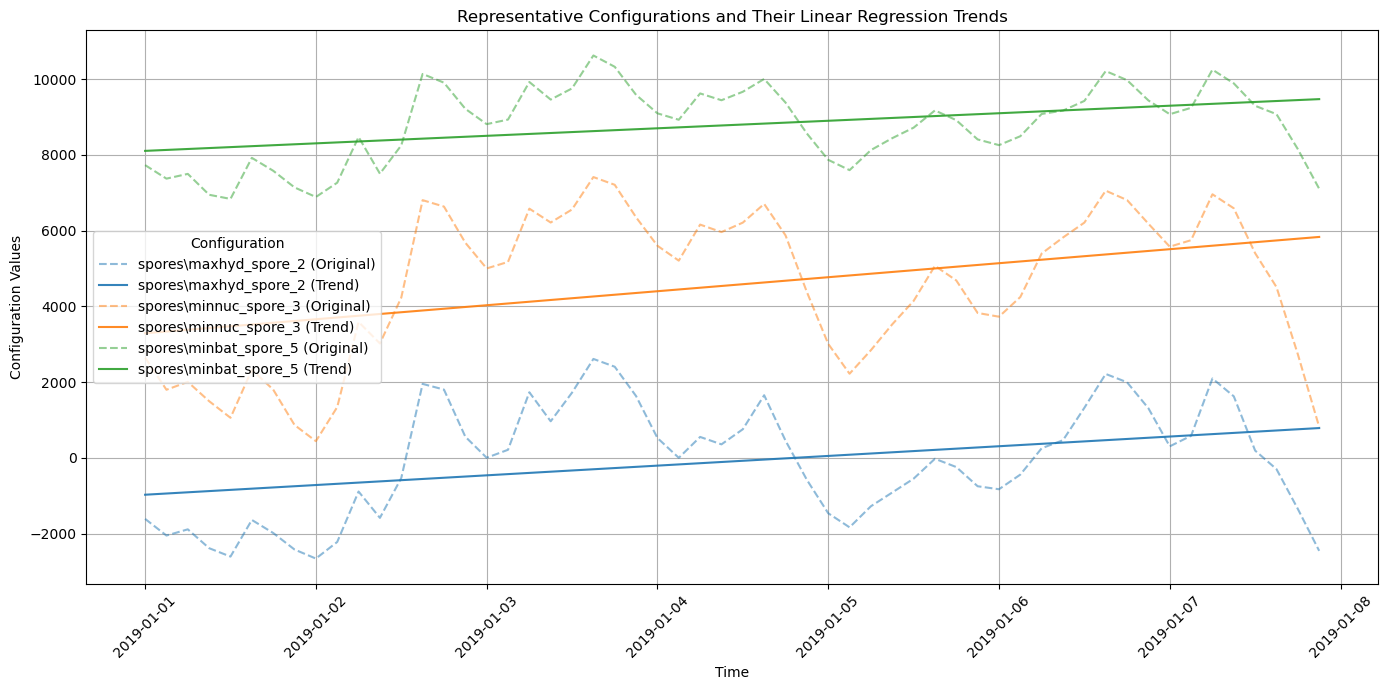

In [15]:
from scipy.stats import linregress
import matplotlib.cm as cm

# Plotting the representative configurations and their linear regression trends

# Initialize the plot
plt.figure(figsize=(14, 7))

# Loop through each representative configuration (row in df_representative_configs)
for i, config in enumerate(df_representative_configs.index):
    # Extract the time series for the current configuration
    config_data = df_representative_configs.loc[config]
    
    # Perform linear regression to get the slope and intercept
    time = np.arange(len(config_data))  # Time indices for each timestep
    slope, intercept, _, _, _ = linregress(time, config_data.values)
    
    # Generate the regression line (linear trend)
    regression_line = slope * time + intercept

    # Use a colormap to assign a unique color for each configuration
    base_color = cm.tab10(i % 10)
    
    # Plot the configuration over time
    plt.plot(df_representative_configs.columns, config_data, label=f'{config} (Original)', linestyle='--', color=base_color, alpha=0.5)
    
    # Plot the linear regression line
    trend_color = base_color
    plt.plot(df_representative_configs.columns, regression_line, label=f'{config} (Trend)', linestyle='-', color=trend_color, alpha=0.9)

# Customize the plot
plt.title('Representative Configurations and Their Linear Regression Trends')
plt.xlabel('Time')
plt.ylabel('Configuration Values')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Configuration')
plt.show()
